In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import magpylib as magpy
from scipy.spatial.transform import Rotation as R
import scipy.constants as constants
import jdc

# Class: Simple Setup

## Methods

### initialize_magnets(mag_dims,remanance_field)
This method must be run before any other analysis may be done. Specifies the layout size and magnetization of the lower magnets in the setup.
* mag_dims: the dimension of the lower magnets in millimeters
* remanance_feild: the magnitization of the four magnets. Often seen on product website listed as $Br_{max}$ or similar

RETURNS: None

### show_magnets()
Displays an interactive veiw of magnetic setup. Here it can be seen that _.initialize_magnets()_ populates the graph with four magnets. Each magnet will have opposing magnitization to the two next to it. Additionally, the magnets are rotated off axis by 45 degrees. This worked better with meshes used in later parts of the code.

RETURNS: plotly 3D graph

In [32]:
class simple_setup:
    def initialize_magnets(self,mag_dims,remanance_field):
        """Defines the magnets to be analyzed by later simple_setup methods. MUST BE
        DEFINED BEFORE OTHER METHODS ARE USED. MAG_DIMS input must be in units of mm.
        Defines magnets off axis, as this works better for the later methods that
        analyze values related to the floating diamagnetic plate. The process for 
        inputing the magnetization of each magnet is also still in the works."""
        self.mag_dims = mag_dims
        dim = mag_dims
        
        self.magnetization = remanance_field
        rotate = R.from_rotvec(np.pi/4*np.array([0,0,1]))
        sqrt2 = np.sqrt(2)

        self.mag_configuration = magpy.Collection()
        cube1 = magpy.magnet.Cuboid(magnetization=(0,0,-1*self.magnetization),dimension=(dim,dim,dim),
                                    position=(0,-1/sqrt2*dim*1.05,-0.5*dim),orientation=rotate)
        cube2 = magpy.magnet.Cuboid(magnetization=(0,0,self.magnetization),dimension=(dim,dim,dim),
                                    position=(dim/sqrt2*1.05,0,-0.5*dim),orientation=rotate)
        cube3 = magpy.magnet.Cuboid(magnetization=(0,0,self.magnetization),dimension=(dim,dim,dim),
                                    position=(-1/sqrt2*dim*1.05,0,-0.5*dim),orientation=rotate)
        cube4 = magpy.magnet.Cuboid(magnetization=(0,0,-1*self.magnetization),dimension=(dim,dim,dim),
                                    position=(0,dim/sqrt2*1.05,-0.5*dim),orientation=rotate)
        self.mag_configuration.add(cube1,cube2,cube3,cube4)
        
    def show_magnets(self):
        """Used to display a visualization of the magnetic setup."""
        self.mag_configuration.show(backend='plotly')

### diamag_plate(side_length,thickness,volume_fraction)
Defines parameters of the levitating diamagnetic plate. In this code, the plate is assumed to be a square prism.
* side_length: side length of plate in mm
* thickness: thickness of plate in mm
* volume_fraction: (0<float<1) volume of graphite in plate divided by total volume of plate. Part not filed with graphite are assumed to be filled with epoxy.

RETURNS: None

In [33]:
%%add_to simple_setup   
def diamag_plate(self,side_length,thickness,volume_fraction):
    """Used to define the side length and thickness of the diamagnetic plate.
    The volume fraction (i.e. volume_graphite/volume_plate) is also defined
    with this method. Further, this method initialzes values that will be used
    by later methods, such as the density of graphite and total density of the
    plate."""
    self.plate_side_length = side_length
    self.plate_thickness = thickness
    self.volume_fraction = volume_fraction

    self.rho_g = 2260
    self.rho_e = 1100
    self.density = self.rho_g*volume_fraction + self.rho_e*(1-volume_fraction)

    self.rho_r = 5e-6
    
    self.plate_volume = (side_length/1000)**2*thickness/1000
    self.plate_mass = self.plate_volume*self.density
    print(self.plate_mass)

### magnetic_feild_graph2D()
Displays a streamplot of the magnetic feild created by the magnet configuration. Additionally, a contour plot is diplayed in the background to show the magnitude of the magnetic field.

RETURNS: matplotlib streamplot/contourf

In [34]:
%%add_to simple_setup    
def magnetic_field_graph2D(self):
    """Used to dipslay a 2D graph of the magnetic feild created by the magnets.
    Can set which direction value equals zero with the zero_direction input."""
    dim = self.mag_dims
    fig, ax = plt.subplots(1, 1, figsize=(13,5))

    # create grid
    ts = np.linspace(-2*dim, 2*dim, 50)
    grid = np.array([[(x,0,z) for x in ts] for z in ts])

    #find magnetic feild on grid
    B = magpy.getB(self.mag_configuration, grid)/1000 #/1000 scales output to units of tesla
    Bamp = np.linalg.norm(B, axis=2)
    
    #create countourplot
    cp = ax.contourf(
        grid[:,:,0], grid[:,:,2], Bamp,
        levels=100,cmap='hsv_r')
    #overlay streamplot
    ax.streamplot(
        grid[:,:,0], grid[:,:,2], B[:,:,0], B[:,:,2],
        density=2,color='black')
    
    #set things on plot
    xlabel = 'x-position [mm]'
    ylabel = 'z-position [mm]'

    ax.set(
        title='Magnetic field of Congfiguration',
        xlabel=xlabel,
        ylabel=ylabel,
        aspect=1)
    
    #include colorbar
    plt.colorbar(cp, ax=ax, label='[T]')

    plt.tight_layout()
    plt.show()

### mag_force(plate_z)
Finds the magnetic force acting on the plate at some point (0,0,z).
* plate_z: the height of the plate off of the magnets

Uses equation (3) from "Diamagnetic composites for high-Q levitating resonators" by Chen et al. (2022). That is,

$\textbf{F}_\textbf{B}=\nabla\int_V\textbf{M}\cdot\textbf{B}{dV}=\frac{\mu_0}{2}\int_V\nabla(\chi_x H_x^2+\chi_y H_y^2 + \chi_z H_z^2){dV}$

where $\chi_x=\chi_y=-85\times 10^{-6}$, and $\chi_z=-450\times 10^{-6}$ are the magnetic susceptibility of the levitating plate in the x,y,z directions, $V$ is the volume of the plate, $\textbf{B}$ is the magnetic field created by the magnets and $\textbf{M}$ is the plate's resulting magnetization. The components of the magnetic field inside the plate are $H_{x,y,z}=B_{x,y,z}/\mu$ where $\mu \approx \mu_0$ is the magnetic permeability of graphite.

RETURNS: numpy array of form (Fx,Fy,Fz) (units: N)

In [35]:
%%add_to simple_setup   
def mag_force(self,plate_z):
    """Calculates the magnetic force on the plate depending on its location."""
    #retrieve previously defined volume fraction
    volume_fraction = self.volume_fraction
    #use directional magnetic susceptibilities from paper.
    sus_x = -85e-6
    sus_y = -85e-6
    sus_z = -450e-6

    xy_points = 10
    z_points = 5

    #retreieve plate dimension
    side_length = self.plate_side_length
    thickness = self.plate_thickness
    dim = self.mag_dims

    #need delta values for integral
    delta_x = side_length/1000/xy_points
    delta_y = side_length/1000/xy_points
    delta_z = thickness/1000/z_points
    delta_V = delta_x*delta_y*delta_z

    #define grid to find magnetic feild on
    ts = np.linspace(0,side_length,xy_points)
    zs = np.linspace(0,thickness,z_points)+plate_z
    grid = np.array([[[(x,y,z) for z in zs] for y in ts] for x in ts])
    
    #find magnetic feild on grid
    B = magpy.getB(self.mag_configuration,grid)/1000 #/1000 scales to units of T
    #separate into directional components
    Bx = B[:,:,0]
    By = B[:,:,1]
    Bz = B[:,:,2]
    
    #find feild on inside of diamagnetic plate
    Hx = Bx/constants.mu_0 #mu_0 is approximate
    Hy = By/constants.mu_0
    Hz = Bz/constants.mu_0

    #combine the total H-feild for integration
    xterm = sus_x*Hx**2
    yterm = sus_y*Hy**2
    zterm = sus_z*Hz**2

    Htotal_term = xterm+yterm+zterm

    #find the gradient of the H-feild and separate into direction components
    grad_Htotal_components = np.gradient(Htotal_term,*[delta_x,delta_y,delta_z])
    grad_Htotal_x = grad_Htotal_components[0]
    grad_Htotal_y = grad_Htotal_components[1]
    grad_Htotal_z = grad_Htotal_components[2]
    
    #integrate each component to find the directional force vector at that location
    Fx = np.sum(grad_Htotal_x*delta_V*constants.mu_0/2)*volume_fraction
    Fy = np.sum(grad_Htotal_y*delta_V*constants.mu_0/2)*volume_fraction
    Fz = np.sum(grad_Htotal_z*delta_V*constants.mu_0/2)*volume_fraction
    return np.array([Fx,Fy,Fz])

### find_equilibrium_z()
Finds the point where the upwards magnetic force and the downwards gravitational force are balanced. This is the point that you would expect the plate to levitate at. If resulting answer is equal to 0 then the plate would fail to levitate, if it is equal to the dimension of the magnets, then the plate will be ejected away from the plates.

RETURNS: float (>0 but <mag_dims) (units: mm)

In [36]:
%%add_to simple_setup 
def find_equilibrium_z(self):
    """Find the point at which the upward force of the magnetic field is equal
    and opposite to the gravitational force that the plate is also experiencing.
    This tells you how high the plate should settle above the magnets."""
    
    #define space to look for equilibrium z on
    zs = np.linspace(0,self.mag_dims,1000)
    
    #find the total force exerted on the plate at each z location.
    F_z = np.zeros(len(zs))
    Fz_grav = self.plate_mass*constants.g
    for i in range(0,len(zs)):
        Fz_mag = self.mag_force(zs[i])[2]
        F_tot_z = -1*Fz_mag-Fz_grav
        F_z[i]=F_tot_z
    
    #find the point where the total z-force is closest to zero.
    min_force = min(abs(F_z))
    for i in range(0,len(F_z)):
        if abs(F_z[i])==min_force:
            return zs[i]

### z_res_frequency()
Finds the resonant freqency of the plate. For this to be a valid solution, it should be confirmed with _.find_equilibrium_z()_ that the plate does levitate stably. Found using:

$f_{res}=\frac{1}{2\pi}\sqrt{\frac{k}{m}}$ with $k=\frac{dF_z}{dz}|_{z=z_0}$ where $z_0$ is the equilibrium point found above.

RETURNS: float (units: Hz)

In [37]:
%%add_to simple_setup        
def z_res_frequency(self):
    """This finds the resonant freqency of the plate near the equilibrium point.
    This result seems pretty near the results that would be expected based on the
    paper this code was developed from."""
    
    #define points on z axis to determine the total force at each point
    z0 = self.find_equilibrium_z()
    thickness = self.plate_thickness
    z = np.linspace(z0-thickness,z0+thickness,100)
    delta_z = 2*self.plate_thickness/1000/100
    
    #find the force at each point
    F_z = np.zeros(len(z))
    Fz_grav = self.plate_mass*constants.g
    for i in range(0,len(z)):
        Fz_mag = self.mag_force(z[i])[2]
        F_z[i]=Fz_mag
    
    #find the gradient of the z-force at each point and average to find k value
    derFz_dz = np.gradient(F_z,*[delta_z])
    k = np.mean(np.abs(derFz_dz))
    
    #use k value to find f_res
    f_res = 1/(2*np.pi)*np.sqrt(k/self.plate_mass)
    return f_res

### laplacian_B()
Finds $\nabla^2 \textbf{B}$ in the diamagnetic plate. Uses equation (16) from the paper mentioned above. That is,

$\nabla^2 B = \frac{\int_{V_{plate}}(\frac{dB}{dz})^2 {dV_{plate}}}{V_{plate}}$

RETURNS: float (units: $(T/m)^2$)

In [38]:
%%add_to simple_setup
def laplacian_B(self):
    """This function finds the laplacian of B over the volume of the diamagnetic plate.
    This is needed to find the Q of the levitated magnet. Found following equation (2)
    from the paper."""
    xy_points = 10
    z_points = 3

    #define grid in vacinity of plate
    plate_z = self.find_equilibrium_z()
    side_length = self.plate_side_length
    thickness = self.plate_thickness

    ts = np.linspace(0,side_length,xy_points)
    zs = np.linspace(0,thickness,z_points)+plate_z
    
    #deltas needed for integration
    delta_x = side_length/1000/xy_points
    delta_y = side_length/1000/xy_points
    delta_z = thickness/1000/z_points
    delta_V = delta_x*delta_y*delta_z

    #find magnetic feild on gride
    grid = np.array([[[(x,y,z) for z in zs] for y in ts] for x in ts])
    B = magpy.getB(self.mag_configuration,grid)/1000
    B = np.sqrt(B[:,:,:,2]**2+B[:,:,:,1]**2+B[:,:,:,0]**2)
    
    #find gradient of magnetic field
    dBdz = np.gradient(B,*[delta_z],axis=2)

    #integrate via finite sum
    laplac_B = np.sum(dBdz**2*delta_V)/(thickness*side_length**2/1000**3)

    return laplac_B

### find_Q()
Finds the Q value of the oscillating diamagnetic plate. Found using equation (1) from the paper:

$Q = \frac{80\pi f_{res}\rho_r ((\rho_g-\rho_e)+\rho_e/V_r)}{(C_rd)^2\nabla^2 B}$

where $\rho_r$ is the resistivity, $\rho_g$ is the density of graphite, $\rho_e$ is the density of epoxy, $C_r$ is the effective particle size factor, $V_f$ is the volume fraction, and $d$ is the average size of graphite particle in the plate.

RETURNS: float

In [39]:
%%add_to simple_setup    
def find_Q(self):
    """Find the Q value of the osciallating plate under the
    conditions currently defined for this class. Uses equation (1)
    from the paper"""
    
    #find the Q-value
    f_res = self.z_res_frequency()
    laplacian_B = self.laplacian_B()
    V_f = self.volume_fraction
    C_r = 6.3
    rho_g = 2260
    rho_e = 1100
    rho_r = 5e-6
    d = 2.7e-6

    Q_num = 80*f_res*rho_r*(rho_g-rho_e+rho_e/V_f)*np.pi
    Q_den = (C_r*d)**2*laplacian_B

    Q = Q_num/Q_den

    return Q 

### find_acc_sensitivity(tempreature)
* tempreature: tempreature of the setup (in K)

Finds the thermal noise limited acceleration sensitivity of the defined setup. Uses equation (17) from the paper. That is,

$\sqrt{S_{aa}}=\sqrt{\frac{8\pi f_{res} k_{B} T}{mQ}}$

RETURNS: float (units: nano-gs/$\sqrt{\textrm{Hz}}$)

In [40]:
%%add_to simple_setup
def find_acc_sensitivity(self,tempreature):
    """Finds the acceleration sensitivity of the levitated diamagnetic plate.
    Uses equation (17) from the paper."""
    T = tempreature
    f_res = self.z_res_frequency()
    Q = self.find_Q()

    sqrt_Saa = np.sqrt(8*np.pi*f_res*constants.k*T/self.plate_mass/Q)/constants.g*1e9

    return sqrt_Saa

### add_plate(plate_z)
* plate_z: height of plate above magnets (units: mm)

This function adds the plate to the magnet configuration from above to derive emf in a pickup coil. It determines plate magnetization by find the magnetic feild at many points on the diamagnetic plate and then converting this into a auxilary $\textbf{H}$ field before using the magnetic susceptibility to find the total magnetic susceptibility. That is,

$\textbf{H}_{x,y,z}\approx \textbf{B}_{x,y,z}/\mu_0$ and $\textbf{M}_{x,y,z}=\chi_{x,y,z}\textbf{H}_{x,y,z}$

RETURNS: None (adds plate to magnet collection)

### remove_plate()
This function removes the plate from the previous function from the magnetic configuration. This allow it to be placed into a different location later.

RETURNS: None (removes plate from magnet collection)

In [41]:
%%add_to simple_setup
def add_plate(self,plate_z):
    #define variables relevent to plate
    volume_fraction = self.volume_fraction
    sus_x = -85e-6
    sus_y = -85e-6
    sus_z = -450e-6

    xy_points = 5
    z_points = 1

    side_length = self.plate_side_length
    thickness = self.plate_thickness
    dim = self.mag_dims
    
    #need deltas for scaling
    delta_x = side_length/xy_points
    delta_y = side_length/xy_points
    delta_z = thickness/z_points
    delta_V = delta_x*delta_y*delta_z/1000**3
    
    #define grid in vacinity of plate
    ts = np.linspace(-1*side_length/2,side_length/2,xy_points)
    zs = np.linspace(0,thickness,z_points)+plate_z
    
    #define magpy collection that contains the peices of the diamagnetic plate
    self.plate_pieces = []
    for x in ts:
        for y in ts:
            for z in zs:
                #find B at (x,y,z)
                B = magpy.getB(self.mag_configuration,(x,y,z))/1000
                #find H at (x,y,z)
                H = B/constants.mu_0
                #use H to find magnetization at (x,y,z)
                #must multiply by 1000 to sclae to mT for input into magpylib object
                Mx = H[0]*sus_x*1000*self.volume_fraction #units in mT
                My = H[1]*sus_y*1000*self.volume_fraction
                Mz = H[2]*sus_z*1000*self.volume_fraction
                
                #add new object to new magpylib collection
                small_plate = magpy.magnet.Cuboid(magnetization=(Mx,My,Mz),
                                                 position=(x,y,z),
                                                 dimension=(delta_x,delta_y,delta_z))
                self.plate_pieces.append(small_plate)
                
    #add magpylib plate collection to the collection containing the permanent magnets
    self.mag_configuration.add(self.plate_pieces)
    
    
def remove_plate(self):
    #remove plate that was added by the method above.
    self.mag_configuration.remove(self.plate_pieces)

### initialize_pickup_coil(z,radius,turns)
* z: z axis location of pickup coil (units: mm)
* radius: radius of pickup coil (units: mm)
* turns: number of turns in pickup coil

This function initializes the location and other parameters of the pickup coil used for measure the emf due to the movement of the diamagnetic plate.

RETURNS: None

### pickup_coil_flux()
Finds the flux through the pickup coil defined by the method above based off of the current configuration of the magnets and diamagnetic plate.

RETURNS: float (units: $\textrm{T}\cdot\textrm{m}^2$)

In [42]:
%%add_to simple_setup
def initialize_pickup_coil(self,z,radius,turns):
    #define variable relevent to the pickup coil
    #coil assumed to have normal vector in +z direction
    self.pickup_coil_z = z
    self.pickup_coil_radius = radius
    self.pickup_turns = turns

def pickup_coil_flux(self):
    points = 10
    radius = self.pickup_coil_radius
    z = self.pickup_coil_z
    
    #define grid to find magnetic feild on
    R = np.linspace(0,radius,points)
    N = np.arange(points)*10
    N[0] = 1
    
    x_list = []
    y_list = []
    B_flux_list = []
    
    for i in range(0,len(R)):
        delta_R = radius/points
        delta_theta = 2*np.pi/N[i]
        theta = np.linspace(0,2*np.pi,N[i])
        x = R[i]*np.cos(theta)
        y = R[i]*np.sin(theta)
        
        for j in range(0,len(theta)):
            x_list.append(x[j])
            y_list.append(y[j])
            
            #find magnetic feild
            B = magpy.getB(self.mag_configuration,(x[j],y[j],z))/1000
            #only need z-direction of the magnetic feild as coil is oriented on z-axis
            B_flux = B[2]*delta_R/1000*R[i]/1000*delta_theta
            B_flux_list.append(B_flux) 
            
    B_flux_array = np.array(B_flux_list)
    #find sum of all small fluxes
    B_flux_total = np.sum(B_flux_array)
    
    return B_flux_total*self.pickup_turns

### emf(plate_z0,plate_z1,delta_t)
* plate_z0: initial z location of plate
* plate_z1: final z location of plate
* delta_t: time the plate takes to move from *plate_z0* to *plate_z1*

Finds the emf induced in the previously defined pickup coil based on the two heights for the diamagnetic plate and the time interval that the plate takes to move between locations. 

RETURNS: float (units: $T\cdot m^2$)

In [43]:
%%add_to simple_setup

def emf(self,plate_z0,plate_z1,delta_t):
    """Find emf induced in pickup coil due to movement occuring over some time interval"""
    #add plate peices at starting point
    self.add_plate(plate_z0)
    #find flux through pickup coil with plate at initial location
    flux0 = self.pickup_coil_flux()
    #remove the plate
    self.remove_plate()
    #place plate at second specified location
    self.add_plate(plate_z1)
    #find flux through pickup coil with plate at final location
    flux1 = self.pickup_coil_flux()
    #remove plate
    self.remove_plate()
    #find emf
    emf = -1*(flux1-flux0)/delta_t
    return emf

### delta_B(plate_z0,plate_z1,location)
* plate_z0: starting z location of the diamagnetic plate
* plate_z1: ending z location of the diamagnetic plate
* location: location that the change in the magnetic feild is being found at.

Find the change in magentic feild at a location due to the movement of the diamagnetic plate.

RETURNS: float (units: T)

In [44]:
%%add_to simple_setup

def delta_B(self,plate_z0,plate_z1,location):
    """Find the change in magnetic field due to the movement of the plate at some location."""
    self.add_plate(plate_z0)
    B0 = magpy.getB(self.mag_configuration,location)
    B0 = np.sqrt(B0[0]**2+B0[1]**2+B0[2]**2)
    self.remove_plate()
    self.add_plate(plate_z1)
    B1 = magpy.getB(self.mag_configuration,location)
    B1 = np.sqrt(B1[0]**2+B1[1]**2+B1[2]**2)
    delta_B = B1-B0
    return delta_B

### save_model()
Saves specification of model and list of flux through a single coil to files in the same directory. This allows to be done outside of this program.

RETURNS: None (files saved to directory)

In [45]:
%%add_to simple_setup

def save_model(self):
    specs_dict = dict()
    #magnet specs
    specs_dict['magnet_dimensions']=self.mag_dims
    specs_dict['magnet_magnetization']=self.magnetization
    #pickup coil specs (assumes only 1 turn)
    specs_dict['pickup_coil_radius']=self.pickup_coil_radius
    specs_dict['pickup_coil_z']=self.pickup_coil_z
    #plate specifications
    specs_dict['plate_side_length']=self.plate_side_length
    specs_dict['plate_thickness']=self.plate_thickness
    specs_dict['plate_volume_fraction']=self.volume_fraction
    specs_dict['plate_mass']=self.plate_mass*1000 # in grams
    #general information
    specs_dict['levitation_height']=self.find_equilibrium_z()
    specs_dict['resonant_frequency']=self.z_res_frequency()
    specs_dict['theory_Q']=self.find_Q()
    #save data to file
    specs_df = pd.DataFrame(specs_dict.items(),columns=['Quantity','Value'])
    specs_df = specs_df.set_index('Quantity')
    specs_df.to_csv('model_specs.csv')
    print('model_specs.csv saved succesfully')
    
    points = 500
    self.pickup_turns = 1
    z = self.find_equilibrium_z()
    zs = np.linspace(0,2*z,points)
    flux_array = np.zeros(len(zs))
    count = 0
    for i in range(0,len(zs)):
        self.add_plate(zs[i])
        flux = self.pickup_coil_flux()
        flux_array[i]=flux
        self.remove_plate()
        count=count+1
        if count/points*100%20==0:
            print(count/points*100,"% complete")
    
    flux_df=pd.DataFrame()
    flux_df['z_plate']=zs
    flux_df['flux']=flux_array
    flux_df.set_index('z_plate')
    print(flux_df)
    flux_df.to_csv('model_flux.csv')
    print('model_flux.csv saved successfully')

# Tests

In [46]:
mag_config = simple_setup()
mag_config.initialize_magnets(25,1480)
mag_config.diamag_plate(25,1,1)
mag_config.initialize_pickup_coil(0,30,100)

0.0014125000000000003


In [47]:
mag_config.show_magnets()

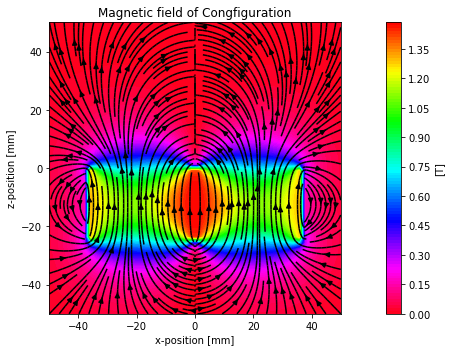

In [48]:
mag_config.magnetic_field_graph2D()

In [49]:
z = mag_config.find_equilibrium_z() #units mm
print(z)

3.6286286286286287


In [50]:
freq = mag_config.z_res_frequency() #units Hz
print(freq)

8.708870436832296


In [51]:
mag_config.find_Q() #unitless

9637392.147376554

In [52]:
mag_config.plate_mass #in kg

0.0014125000000000003

In [53]:
mag_config.emf(0.5*z,1.5*z,1/freq/2) #units V

-0.40239580325385715

In [54]:
mag_config.find_acc_sensitivity(273)

0.000793832984363591